In [2]:
# === Bootstrap Silhouette Bands (2 states) ===
# Inputs: two CSVs with ['middle_x','middle_y','middle_z']
# Outputs:
#   - out_dir/overlay_[x|y|z]_bands.png (A vs B bands + medians)
#   - out_dir/metrics.csv (IoU@p50, BO@p80/p95, meanNN, Hausdorff)
#   - out_dir/prob_[A|B]_[x|y|z].npy (per-view probability maps)
# Notes: tune grid_base, sigma_vox, q_metaball, n_boot, sample_frac for speed/quality.

import os, json, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, List
from scipy.ndimage import gaussian_filter, label, binary_closing
from scipy.spatial import cKDTree
from skimage.measure import find_contours
np.set_printoptions(suppress=True)

# Config
@dataclass
class Cfg:
    grid_base: int = 160          # 3D grid longest side
    pad_frac: float = 0.05
    sigma_vox: float = 3.0         # 3D Gaussian (voxels)
    q_metaball: float = 0.90       # keep top (1-q) of positive field
    min_blob_vox: int = 200
    post_close: int = 1

    n_boot: int = 128
    sample_frac: float = 0.90      # genes per bootstrap (with replacement)

    band_levels: Tuple[float,...] = (0.60, 0.80, 0.95)  # probability bands
    median_level: float = 0.50

    trim_q: float = 0.10           # ICP trimming
    icp_iters: int = 30
    sample_icp: int = 50000
    out_dir: str = "out_boot_silhouettes_2state"

LABEL_A = "12 h — UNTR"
LABEL_B = "12 h — VACV"

# IO 
def load_points(csv):
    df = pd.read_csv(csv)
    P = df[["middle_x","middle_y","middle_z"]].dropna().values.astype(np.float32)
    if len(P) < 50:
        raise ValueError(f"Too few points in {csv}")
    return P

#  Alignment 
def pca_axes(pts: np.ndarray):
    C = np.cov((pts - pts.mean(0)).T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]]
    if np.linalg.det(V) < 0:
        V[:, -1] *= -1
    return V

def nn_metrics(A_pts, B_pts):
    ta, tb = cKDTree(A_pts), cKDTree(B_pts)
    dBA,_ = ta.query(B_pts, k=1); dAB,_ = tb.query(A_pts, k=1)
    rmse = float(np.sqrt((np.concatenate([dBA, dAB])**2).mean()))
    haus = float(max(dBA.max(), dAB.max()))
    return rmse, haus

def best_pca_prealign(B_pts, A_pts):
    Va, Vb = pca_axes(A_pts), pca_axes(B_pts)
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1,-1], repeat=3))
    best_R, best_rmse = np.eye(3), np.inf
    for p in perms:
        P = np.zeros((3,3)); P[range(3), list(p)] = 1
        for s in signs:
            S = np.diag(s)
            R = Va @ (P @ S) @ Vb.T
            rmse,_ = nn_metrics(A_pts, B_pts @ R.T)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R

def kabsch(P, Q):
    Pc, Qc = P.mean(0), Q.mean(0)
    P0, Q0 = P - Pc, Q - Qc
    H = Q0.T @ P0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1; R = Vt.T @ U.T
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=11):
    rs = np.random.default_rng(seed)
    A = A_pts if len(A_pts)<=sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts)<=sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    R, t = np.eye(3), np.zeros(3)
    for _ in range(iters):
        Bx = B @ R.T + t
        tree = cKDTree(A); d, idx = tree.query(Bx, k=1)
        P = A[idx]
        if 0.0 < trim_q < 0.5:
            thr = np.quantile(d, 1 - trim_q); keep = d <= thr
            P, Bx = P[keep], Bx[keep]
        R_upd, t_upd = kabsch(P, Bx)
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

#  3D grid & metaball 
def make_grid_from_bounds(P: np.ndarray, base=160, pad_frac=0.05):
    mn, mx = P.min(0), P.max(0)
    ext = mx - mn
    pad = pad_frac * float(ext.max()); mn -= pad; mx += pad; ext = mx - mn
    scale = base / float(ext.max() + 1e-8)
    dims = np.clip(np.ceil(ext * scale).astype(int), 32, 512)
    edges = [np.linspace(mn[i], mx[i], dims[i] + 1, dtype=np.float32) for i in range(3)]
    return edges, dims

def metaball_mask(P: np.ndarray, edges, sigma_vox=3.0, q=0.90, min_blob_vox=200):
    H, _ = np.histogramdd(P, bins=edges); H = H.astype(np.float32)
    F = gaussian_filter(H, sigma=(sigma_vox, sigma_vox, sigma_vox), mode="constant")
    vals = F[F>0]
    if vals.size == 0: return None
    thr = float(np.quantile(vals, q))
    M = (F >= thr)
    lbl, nlab = label(M)
    if nlab>0:
        sizes = np.bincount(lbl.ravel())
        keep = np.where((np.arange(len(sizes))>0) & (sizes>=min_blob_vox))[0]
        M = np.isin(lbl, keep)
    # reorder to (Z,Y,X) for projections
    return np.transpose(M, (2,1,0))

# 2D projections & contours 
def orthographic_mask_2d(M_zyx: np.ndarray, axis: str, post_close=1):
    if axis == 'z':   S = M_zyx.max(axis=0)  # [y,x]
    elif axis == 'y': S = M_zyx.max(axis=1)  # [z,x]
    elif axis == 'x': S = M_zyx.max(axis=2)  # [z,y]
    else: raise ValueError
    S = S.astype(bool)
    if post_close > 0:
        from scipy.ndimage import generate_binary_structure, binary_closing
        st = generate_binary_structure(2,1)
        for _ in range(post_close):
            S = binary_closing(S, structure=st)
    return S

def contour_at_prob(Pmap: np.ndarray, level: float):
    cs = find_contours(Pmap, level=level)
    if not cs: return None
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

def iou(A: np.ndarray, B: np.ndarray) -> float:
    inter = np.logical_and(A,B).sum()
    union = np.logical_or(A,B).sum()
    return float(inter) / float(union + 1e-9)

def contour_distances(CA, CB) -> Tuple[float,float]:
    if CA is None or CB is None: return float('nan'), float('nan')
    TA, TB = cKDTree(CA), cKDTree(CB)
    da,_ = TA.query(CB, k=1); db,_ = TB.query(CA, k=1)
    return float((da.mean()+db.mean())/2.0), float(max(da.max(), db.max()))

#  Bootstrap per state 
def boot_prob_maps(P: np.ndarray, edges, cfg: Cfg) -> Dict[str, np.ndarray]:
    n = len(P); k = max(1, int(round(cfg.sample_frac * n)))
    # we don't store all masks; we accumulate probability per view
    acc = {a: None for a in ('x','y','z')}
    for b in range(cfg.n_boot):
        idx = np.random.choice(n, size=k, replace=True)
        M = metaball_mask(P[idx], edges, sigma_vox=cfg.sigma_vox, q=cfg.q_metaball, min_blob_vox=cfg.min_blob_vox)
        if M is None: continue
        for a in ('x','y','z'):
            S = orthographic_mask_2d(M, a, post_close=cfg.post_close).astype(np.uint16)
            if acc[a] is None: acc[a] = S
            else: acc[a] += S
    # normalize to 0..1
    out = {a: (acc[a].astype(np.float32)/float(cfg.n_boot)) if acc[a] is not None else None for a in acc}
    return out

# Plot bands
def draw_bands(ax, Pmap, levels, color, label):
    # filled bands from outer→inner; then median line
    prev = None
    for lv in sorted(levels):
        M = (Pmap >= lv)
        ax.imshow(M, cmap='Greys', alpha=0)  # noop to keep extents consistent
        # plot outer boundary of this level
        C = contour_at_prob(Pmap, lv)
        if C is not None:
            ax.plot(C[:,1], C[:,0], lw=2, color=color, alpha=0.75, label=f"{label} p≥{int(lv*100)}" if lv==levels[0] else None)
        prev = M
    # median
    Cm = contour_at_prob(Pmap, 0.5)
    if Cm is not None:
        ax.plot(Cm[:,1], Cm[:,0], lw=3, color=color, alpha=1.0)

def save_overlay_bands(PA, PB, cfg: Cfg, axis: str, nameA: str, nameB: str):
    fig, ax = plt.subplots(figsize=(5.2,5.2))
    ax.imshow(np.logical_or(PA>=cfg.band_levels[0], PB>=cfg.band_levels[0]), cmap="gray", alpha=0.12)
    draw_bands(ax, PA, cfg.band_levels, "#1f77b4", nameA)   # blue
    draw_bands(ax, PB, cfg.band_levels, "#d62728", nameB)   # red
    ax.set_title(f"Bootstrap silhouettes — {axis.upper()} view")
    ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    os.makedirs(cfg.out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(cfg.out_dir, f"overlay_{axis}_bands.png"), dpi=220)
    plt.close()

# Main 
def run_bootstrap_silhouettes(csv_A: str, csv_B: str, cfg=Cfg(), labelA=LABEL_A, labelB=LABEL_B):
    # make sure outputs folder exists before any saves
    os.makedirs(cfg.out_dir, exist_ok=True)
    
    # 1) load & center
    A_raw, B_raw = load_points(csv_A), load_points(csv_B)
    A0, B0 = A_raw - A_raw.mean(0), B_raw - B_raw.mean(0)

    # 2) align B->A (best-PCA, then ICP)
    Rpre = best_pca_prealign(B0, A0)
    B1 = B0 @ Rpre.T
    Ricp, ticp = icp_rigid_robust(A0, B1, iters=cfg.icp_iters, sample=cfg.sample_icp, trim_q=cfg.trim_q)
    A_al, B_al = A0, (B1 @ Ricp.T + ticp)

    # 3) uniform scale (shared bbox) so probabilities compare
    mins = np.vstack([A_al, B_al]).min(0); maxs = np.vstack([A_al, B_al]).max(0)
    s = float((maxs - mins).max()); A = A_al/s; B = B_al/s

    # 4) shared grid and bootstrap probability maps
    edges, _ = make_grid_from_bounds(np.vstack([A, B]), base=cfg.grid_base, pad_frac=cfg.pad_frac)
    PA = boot_prob_maps(A, edges, cfg)
    PB = boot_prob_maps(B, edges, cfg)

    # 5) save prob maps & overlays
    for a in ('x','y','z'):
        if PA[a] is None or PB[a] is None: continue
        np.save(os.path.join(cfg.out_dir, f"prob_A_{a}.npy"), PA[a])
        np.save(os.path.join(cfg.out_dir, f"prob_B_{a}.npy"), PB[a])
        save_overlay_bands(PA[a], PB[a], cfg, a, labelA, labelB)

    # 6) metrics (per view; medians at p=0.5; band overlaps at 0.80/0.95)
    rows = []
    for a in ('x','y','z'):
        if PA[a] is None or PB[a] is None: continue
        SA50 = PA[a] >= 0.5; SB50 = PB[a] >= 0.5
        i = iou(SA50, SB50)
        BO80 = iou(PA[a] >= 0.80, PB[a] >= 0.80)
        BO95 = iou(PA[a] >= 0.95, PB[a] >= 0.95)
        CA, CB = contour_at_prob(PA[a], 0.5), contour_at_prob(PB[a], 0.5)
        mnn, haus = contour_distances(CA, CB)
        rows.append(dict(view=a.upper(), IoU_p50=i, BO80=BO80, BO95=BO95, meanNN=mnn, Hausdorff=haus))
    df = pd.DataFrame(rows)
    os.makedirs(cfg.out_dir, exist_ok=True)
    df.to_csv(os.path.join(cfg.out_dir, "metrics.csv"), index=False)

    meta = dict(csv_A=csv_A, csv_B=csv_B, label_A=labelA, label_B=labelB, cfg=cfg.__dict__)
    with open(os.path.join(cfg.out_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    print(df)
    print(f"Saved overlays & metrics in: {cfg.out_dir}")

# run 
if __name__ == "__main__":
    CSV_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv"
    CSV_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"
    run_bootstrap_silhouettes(CSV_A, CSV_B, Cfg(
        grid_base=160, pad_frac=0.05, sigma_vox=3.0, q_metaball=0.90,
        min_blob_vox=200, post_close=1,
        n_boot=128, sample_frac=0.90,
        band_levels=(0.60,0.80,0.95), median_level=0.50,
        trim_q=0.10, icp_iters=30, sample_icp=50000,
        out_dir="data/green_monkey/va_testing/out_chr1_12h_untr_vs_vacv_boot"
    ), labelA=LABEL_A, labelB=LABEL_B)


  view   IoU_p50      BO80      BO95    meanNN  Hausdorff
0    X  0.598035  0.539881  0.441642  6.116673  27.171888
1    Y  0.499609  0.381496  0.275747  7.874378  26.675896
2    Z  0.571396  0.474927  0.393698  7.394759  23.405877
Saved overlays & metrics in: data/green_monkey/va_testing/out_chr1_12h_untr_vs_vacv_boot


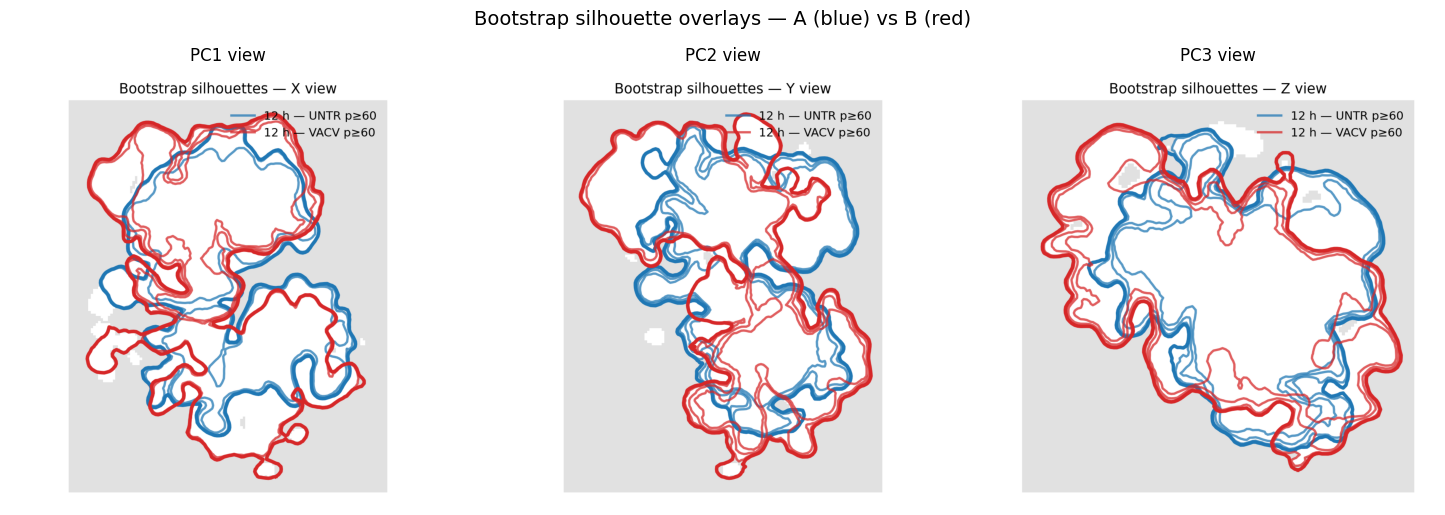

/var/folders/29/w54hnxjs18q9cvq1pfzwym540000gn/T/ipykernel_16555/1503487671.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


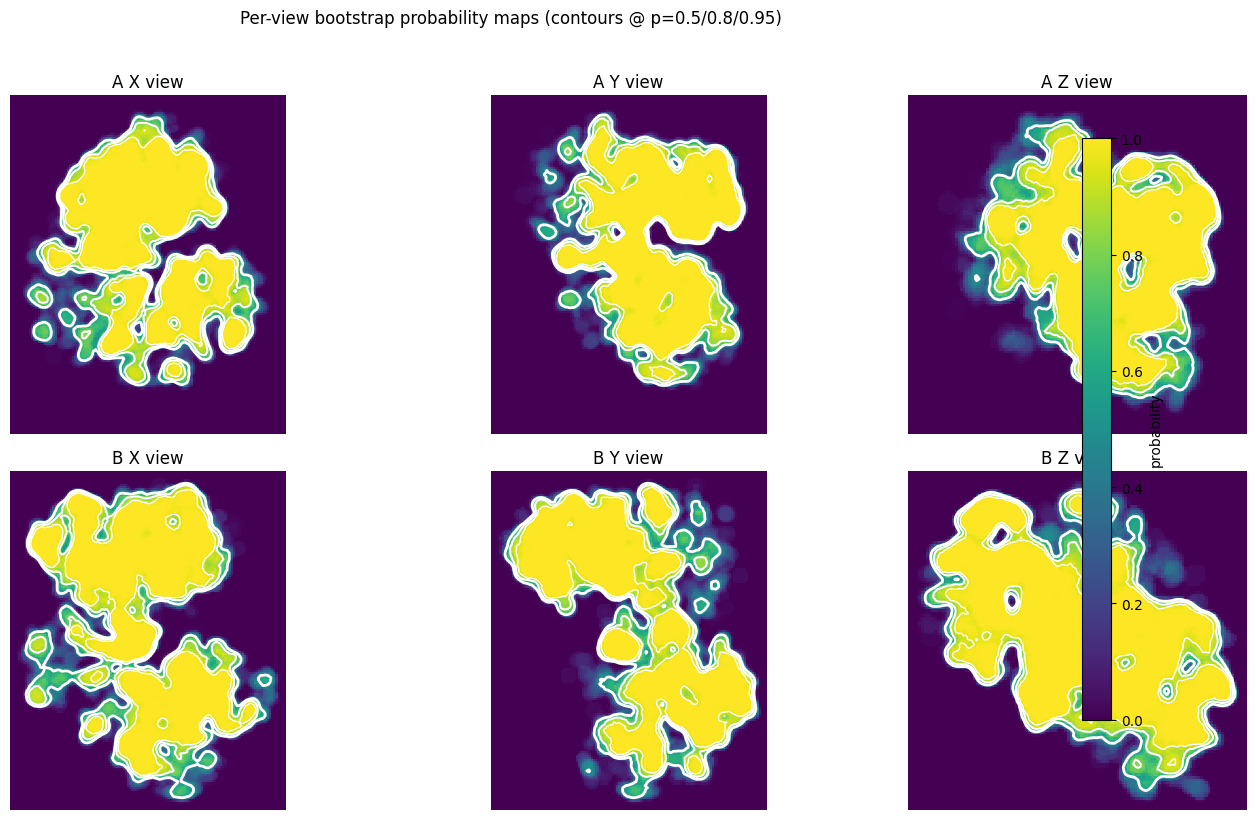

In [3]:
import os, numpy as np, matplotlib.pyplot as plt, matplotlib.image as mpimg

OUT = "data/green_monkey/va_testing/out_chr1_12h_untr_vs_vacv_boot"  #  out_dir

# ---- 1) Show overlay band PNGs (X/Y/Z = PC1/PC2/PC3) ----
paths = [os.path.join(OUT, f"overlay_{ax}_bands.png") for ax in ("x","y","z")]
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for ax, p, ttl in zip(axs, paths, ["PC1 view", "PC2 view", "PC3 view"]):
    if os.path.exists(p):
        ax.imshow(mpimg.imread(p))
        ax.set_title(ttl, fontsize=12)
    else:
        ax.text(0.5, 0.5, f"Missing {os.path.basename(p)}", ha="center", va="center")
    ax.axis("off")
plt.suptitle("Bootstrap silhouette overlays — A (blue) vs B (red)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# ---- 2) Show raw probability maps with contours (for both A and B) ----
def show_all_prob_maps():
    fig, axs = plt.subplots(2, 3, figsize=(15,8))
    for j, ax_tag in enumerate(["x","y","z"]):
        pa = os.path.join(OUT, f"prob_A_{ax_tag}.npy")
        pb = os.path.join(OUT, f"prob_B_{ax_tag}.npy")
        if not (os.path.exists(pa) and os.path.exists(pb)):
            axs[0,j].axis("off"); axs[1,j].axis("off")
            continue
        PA, PB = np.load(pa), np.load(pb)
        for row,(arr,label) in enumerate([(PA,"A"),(PB,"B")]):
            ax = axs[row,j]
            im = ax.imshow(arr, vmin=0, vmax=1, cmap="viridis", interpolation="nearest")
            ax.contour(arr, levels=[0.5,0.8,0.95], colors="white", linewidths=(2,1.5,1))
            ax.set_title(f"{label} {ax_tag.upper()} view")
            ax.axis("off")
    fig.colorbar(im, ax=axs.ravel().tolist(), fraction=0.025, pad=0.02, label="probability")
    plt.suptitle("Per-view bootstrap probability maps (contours @ p=0.5/0.8/0.95)", y=1.02)
    plt.tight_layout()
    plt.show()

# Call to see probability maps for all 3 views
show_all_prob_maps()
